# Kalman Filters
#### _`Optimal Estimator for Continuously Changing Systems`_
---


### $$\textit{"Shifting into a New Dimensionality"}$$

$\text{Mean Vector}$
>One element for each dimension

$$\mu = \begin{bmatrix} \mu_1 \\ \mu_2 \\ \vdots \\ \mu_n \end{bmatrix}$$ 

<br>
$\text{Covariance Matrix}$
>The diagonal contains the variance for each variable, and the off-diagonal elements contain the covariance between the $i^{th}$ and $j^{th}$ variables. 

$$\Sigma =\begin{bmatrix} \sigma^2_{1} & \sigma_{12} & \dots & \sigma_{1n} \\
                          \sigma_{21} & \sigma^2_{2} & \dots & \sigma_{2n} \\
                          \vdots & \vdots & \ddots & \vdots \\
                          \sigma_{n1} & \sigma_{n2} & \dots & \sigma^2_{n}
\end{bmatrix}$$

<br>

---


## Two Step Process:

>### Measurement update |  _`Sense` , `Correction`_ $^1$

<p>
<img src='img/kf-measurement-sense.svg' width='500' height='500'>
</p>

<br>

>### Motion update | _`Prediction`_ $^1$

<p>
<img src='img/motion-prediction.svg' width='500' height='500'>
</p>

<br>

### KF Update Cycle $^2$

<p>
  <img src='img/Kalman-Filter-Steps.png' width='1000' height='1000'>

</p>



<br>

# `Univariate` Kalman Filter

## `Bayes' Rule` Measurement Update

$\mu$ = prior mean

$\sigma^2$ = prior variance

$v$ (aka $\mu2 $) = mean "likelihood"

$r^2$ (aka $\sigma2 $) = variance "likelihood"

$$\text{New Mean}$$
## $$\mu^` = \frac{r^2 \mu + \sigma^2 v}{r^2 + \sigma^2}$$

<br>
<br>

$$\text{New Variance}$$
## $$\sigma^2` = \frac{1}{\frac{1}{r^2} + \frac{1}{\sigma^2}}$$

In [23]:
def measurement_update(mu1, s1, mu2, s2):
    new_mean = (s2 * mu1 + s1 * mu2) / (s2 + s1)
    new_var = 1 / (1/s2 + 1/s1)
    return [new_mean, new_var]

def predict(mean1, var1, mean2, var2):
    new_mean = mean1 + mean2
    new_var = var1 + var2
    return [new_mean, new_var]


In [24]:
measurement_update(22., 11., 15., 3.)

[16.5, 2.357142857142857]

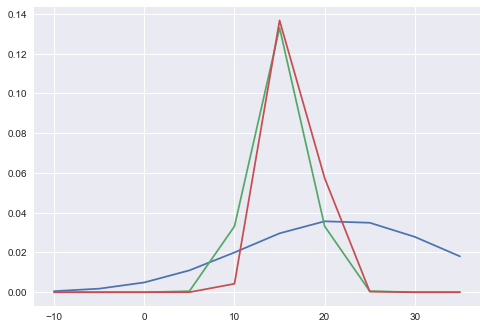

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from scipy.stats import norm

x_axis = np.arange(-10, 40, 5)

plt.plot(x_axis, norm.pdf(x_axis, 22, 11))
plt.plot(x_axis, norm.pdf(x_axis, 15, 3))
plt.plot(x_axis, norm.pdf(x_axis, 16.5, 2.4))


plt.show();

In [26]:
assert predict(22., 11., 15., 3.) == [37.0, 14.0]  # Introducing more uncertainty

<br>

---

# `Multivariate` Kalman Filter $^3$

In [27]:
x = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T  # Initial State
n = x.size
P = np.diag([100.0, 100.0, 10.0, 10.0, 1.0, 1.0])  # Initial Uncertainty

dt = 0.2 # Time Step between Filter Steps

A = np.matrix([[1.0, 0.0, dt, 0.0, 1/2.0*dt**2, 0.0],
              [0.0, 1.0, 0.0, dt, 0.0, 1/2.0*dt**2],
              [0.0, 0.0, 1.0, 0.0, dt, 0.0],
              [0.0, 0.0, 0.0, 1.0, 0.0, dt],
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])  # Dynamic Matrix - Egomotion

H = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])  # Measurement Matrix


rA = 10.0**2   # Noise of Acceleration Measurement
rP = 100.0**2  # Noise of Position Measurement

R = np.matrix([[rP, 0.0, 0.0, 0.0],
               [0.0, rP, 0.0, 0.0],
               [0.0, 0.0, rA, 0.0],
               [0.0, 0.0, 0.0, rA]])  # Measurement Noise Covariance


# Processed Noise
sA = 0.001
G = np.matrix([[1/2.0 * dt**2],
               [1/2.0 * dt**2],
               [dt],
               [dt],
               [1.0],
               [1.0]])  # PN Covariance Matrix

Q = G * G.T * sA**2

I = np.eye(n)  # Good old friend, the Identity Matrix


### Position

In [28]:
m = 400 # Measurements

sP = 1.0 # Sigma for position
pX = 0.0 # x Position
pY = 0.0 # y Position

mpX = np.array(pX + sP*np.random.randn(m))
mpY = np.array(pY + sP*np.random.randn(m))

# Generate GPS Trigger
gps = np.ndarray(m,dtype='bool')
gps[0]= True

# Less new position updates
for i in range(1,m):
    if i%10 == 0:
        gps[i]= True
    else:
        mpX[i] = mpX[i-1]
        mpY[i] = mpY[i-1]
        gps[i] = False

### Acceleration

In [29]:
# Acceleration
sa = 0.1 # Sigma for acceleration
aX = 0.0 # in X
aY = 0.0 # in Y

mX = np.array(aX + sa*np.random.randn(m))
mY = np.array(aY + sa*np.random.randn(m))

measurements = np.vstack((mpX, mpY, mX, mY))

In [30]:
# Placeholders for plotting via capture_states()
Xt = []
Yt = []

dXt= []
dYt= []
ddXt=[]
ddYt=[]

Zx = []
Zy = []

Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]

Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
Kddy=[]


def capture_states(x, Z, P, K):
    Xt.append(float(x[0]))
    Yt.append(float(x[1]))
    
    dXt.append(float(x[2]))
    dYt.append(float(x[3]))
    ddXt.append(float(x[4]))
    ddYt.append(float(x[5]))
    
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Pddy.append(float(P[5,5]))
    
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))
    Kddy.append(float(K[5,0]))

In [31]:

for step in range(m):
    
    # Time Update === Prediction

    # Project the state ahead
    x = A * x
    
    # Project the error covariance ahead
    P = A * P * A.T + Q    
    
    
    # Measurement Update ==== Correction, Sense

    if gps[step]:
        # Compute the Kalman Gain
        S = H * P*H.T + R
        K = (P*H.T) * np.linalg.pinv(S)
    
        
        # Update the estimate via z
        Z = measurements[:,step].reshape(H.shape[0],1)
        y = Z - (H * x)  # Innovation or Residual
        x = x + (K * y)
        
        # Update the error covariance
        P = (I - (K*H))* P

   
    
    # Save states for Plotting
    capture_states(x, Z, P, K)

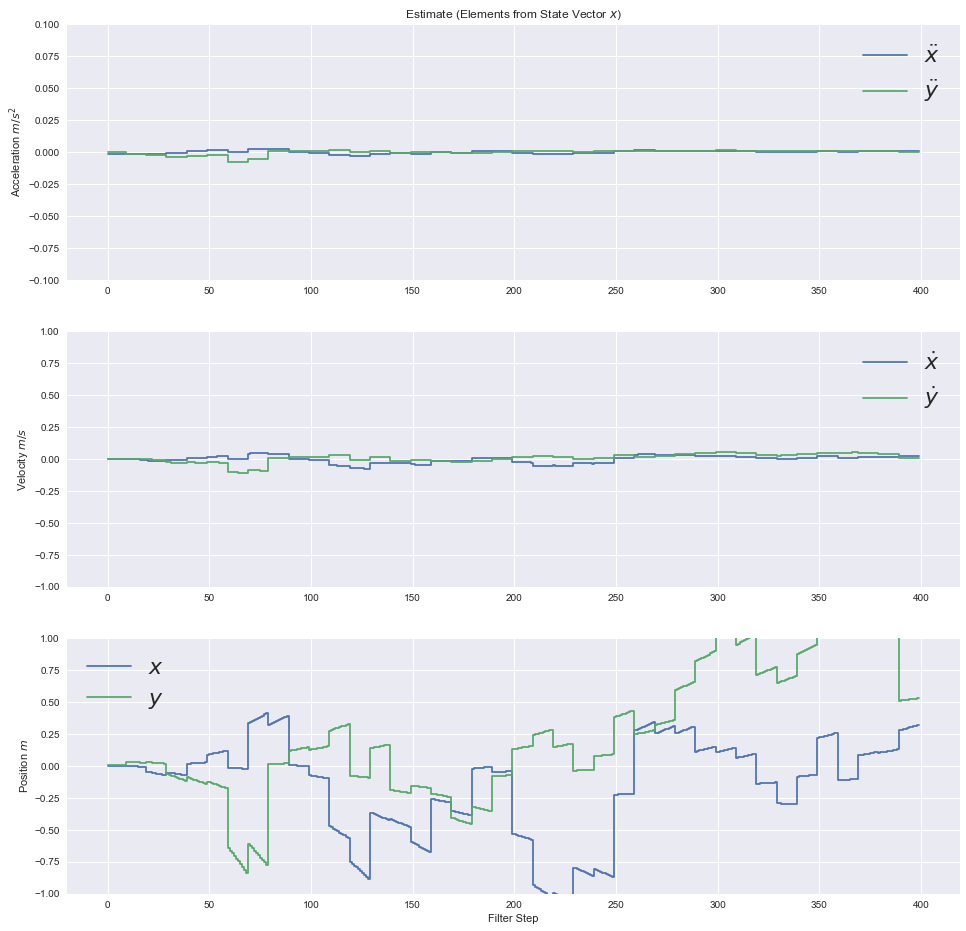

In [32]:
fig = plt.figure(figsize=(16,16))

plt.subplot(311)
plt.step(range(len(measurements[0])),ddXt, label='$\ddot x$')
plt.step(range(len(measurements[0])),ddYt, label='$\ddot y$')

plt.title('Estimate (Elements from State Vector $x$)')
plt.legend(loc='best',prop={'size':22})
plt.ylabel(r'Acceleration $m/s^2$')
plt.ylim([-.1,.1])

plt.subplot(312)
plt.step(range(len(measurements[0])),dXt, label='$\dot x$')
plt.step(range(len(measurements[0])),dYt, label='$\dot y$')

plt.ylabel('')
plt.legend(loc='best',prop={'size':22})
plt.ylabel(r'Velocity $m/s$')
plt.ylim([-1,1])

plt.subplot(313)
plt.step(range(len(measurements[0])),Xt, label='$x$')
plt.step(range(len(measurements[0])),Yt, label='$y$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.legend(loc='best',prop={'size':22})
plt.ylabel(r'Position $m$')
plt.ylim([-1,1])
plt.show();

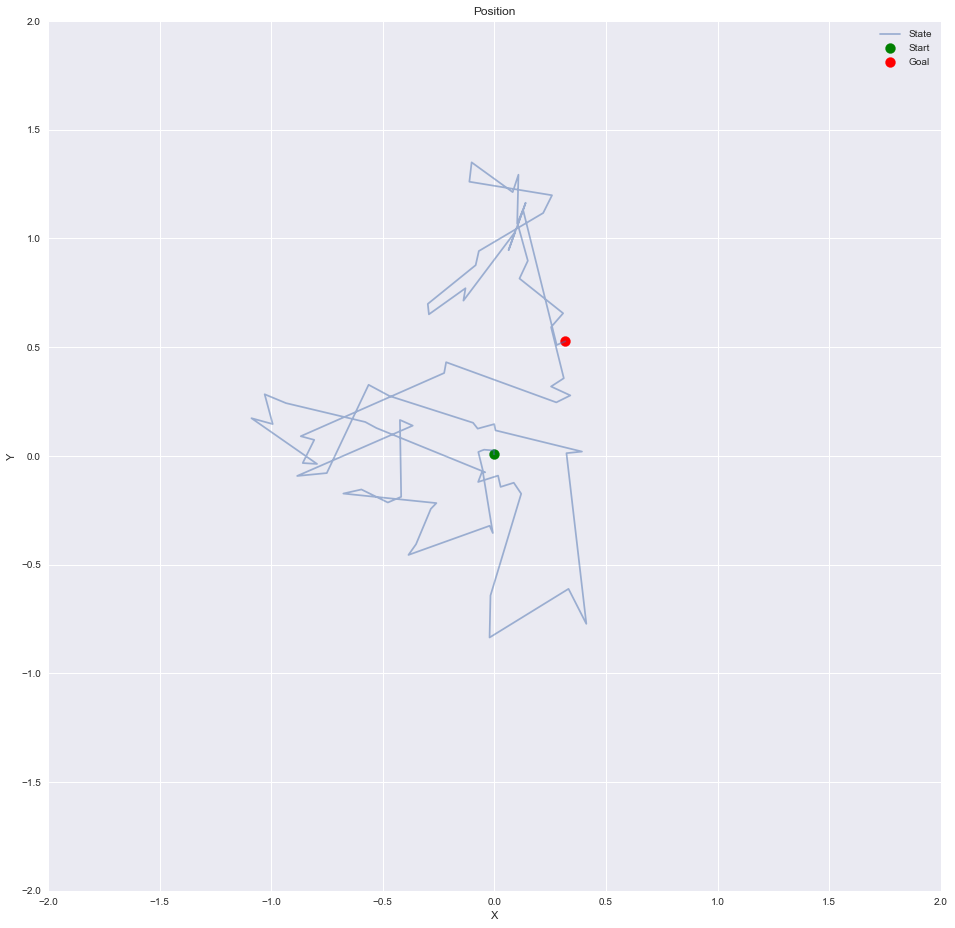

In [33]:
fig = plt.figure(figsize=(16,16))
plt.plot(Xt,Yt, label='State',alpha=0.5)
plt.scatter(Xt[0],Yt[0], s=100, label='Start', c='g')
plt.scatter(Xt[-1],Yt[-1], s=100, label='Goal', c='r')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Position')
plt.legend(loc='best')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.show();

---

**Citations:**
   1. "Kalman Filter book using Jupyter Notebook": https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python
   2. "Python Implementations of the Kalman Filter": https://github.com/balzer82/Kalman
   3.  Adapted simple Mulitvariate approach from synthetic data examples: https://github.com/balzer82/Kalman